In [31]:
import numpy as np
import pandas as pd
import re
import time
import string
import unicodedata
import spacy
import torch

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments
from google_play_scraper import Sort, reviews
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from transformers import Trainer
import torch.nn.functional as F



In [32]:
result, continuation_token = reviews(
    'com.miHoYo.GenshinImpact',
    lang='pt', # defaults to 'en'
    country='BR', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.NEWEST
    count=200, # defaults to 100
    filter_score_with=None # defaults to None(means all score)
)

# If you pass `continuation_token` as an argument to the reviews function at this point,
# it will crawl the items after 3 review items.

result, _ = reviews(
    'com.miHoYo.GenshinImpact',
    continuation_token=continuation_token # defaults to None(load from the beginning)
)

df = pd.DataFrame(result)
df[['content', 'score']].head()


,content,score
0,"Muito ruim, não dá pra ver a calcinha das pers...",1
1,Muito bom,5
2,cd a Paimon 8 estrelad,1
3,O jogo é muito bom mais seria bom pra dar pra ...,5
4,"Jogo é perfeitamente incrível, não limitar nad...",2


### Sentimento
Adicionando uma nova coluna sentimento que será usada como "label", em que:
* 1 e 2 estrelas é sentimento “negativo”. 
* 3 estrelas é “neutro”. 
* 4 e 5 estrelas é “positivo”.

In [33]:
def set_sentimento(score):
    if score <= 2:
        return "negativo"
    elif score == 3:
        return "neutro"
    else:
        return "positivo"

In [34]:
df['sentimento'] = df['score'].apply(set_sentimento)
df[['content', 'score', 'sentimento']].head()

,content,score,sentimento
0,"Muito ruim, não dá pra ver a calcinha das pers...",1,negativo
1,Muito bom,5,positivo
2,cd a Paimon 8 estrelad,1,negativo
3,O jogo é muito bom mais seria bom pra dar pra ...,5,positivo
4,"Jogo é perfeitamente incrível, não limitar nad...",2,negativo


### Análise dos dados
* Esse é um problema com desbalanceamento de classes? 
* Qual é a distribuição dos tamanhos das reviews? 
* Quais são as palavras mais frequentes? 

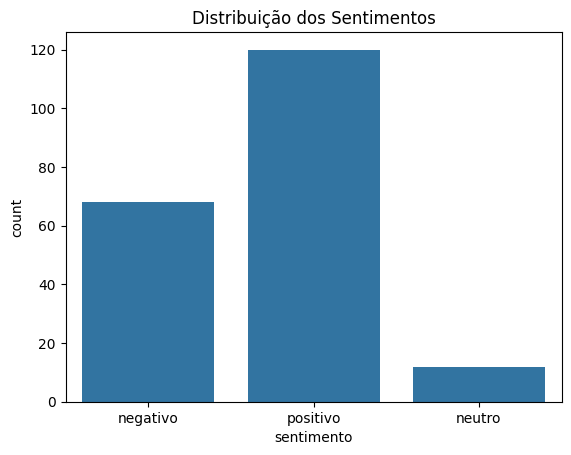

Quantidade de Sentimentos Positivos: 120
Quantidade de Sentimentos Negativos: 68
Quantidade de Sentimentos Neutros: 12


D:\Temp\ipykernel_22408\1820044318.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Quantidade de Sentimentos Positivos:', sentimento_counts[0])
D:\Temp\ipykernel_22408\1820044318.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Quantidade de Sentimentos Negativos:', sentimento_counts[1])
D:\Temp\ipykernel_22408\1820044318.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Quantidade de Sentimentos Neu

In [35]:
#Desbalanceamento de Classes
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem dos sentimentos
sentimento_counts = df['sentimento'].value_counts()

# Visualização da distribuição
sns.countplot(x='sentimento', data=df)
plt.title('Distribuição dos Sentimentos')
plt.show()

print('Quantidade de Sentimentos Positivos:', sentimento_counts[0])
print('Quantidade de Sentimentos Negativos:', sentimento_counts[1]) 
print('Quantidade de Sentimentos Neutros:', sentimento_counts[2]) 

Como podemos ver no gráfico acima, temos um problema de desbalanceamento de classes. Por isso, usaremos como métrica principal o f1_score e técnicas de balanceamento como SMOTE e pesos de classe.

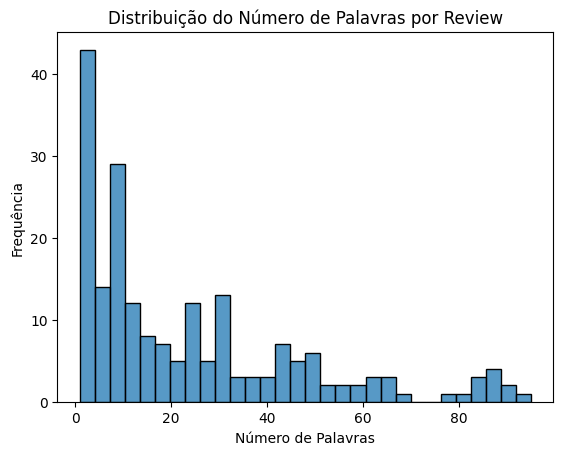

Máximo de palavras em uma linha: 95


In [36]:
# Número de palavras por review
df['num_palavras'] = df['content'].str.split().apply(len)

sns.histplot(data=df, x='num_palavras', bins=30)
plt.title('Distribuição do Número de Palavras por Review')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.show()

print('Máximo de palavras em uma linha:', df['num_palavras'].max())

Antes de fazer a análise da frequência das palavras é preciso preparar os dados.

In [37]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

baixar o modelo pt_core_news_sm para usar Lematização
* python -m spacy download pt_core_news_sm

In [38]:
# Funções de Pré-processamento e tokenização
def normalize_accents(text):
    return unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("utf-8")

def normalize_str(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = normalize_accents(text)
    text = re.sub(re.compile(r" +"), " ",text)
    return " ".join([w for w in text.split()])

def remove_punctuation(text):
    punctuations = string.punctuation
    table = str.maketrans({key: " " for key in punctuations})
    text = text.translate(table)
    return text


def tokenizer(text):
    nlp = spacy.load('pt_core_news_sm')
    doc = nlp(text)
    stop_words = nltk.corpus.stopwords.words("portuguese") # english, caso o dataset seja em ingles
    if isinstance(text, str):
        text = normalize_str(text)
        text = "".join([w for w in text if not w.isdigit()])
        text = word_tokenize(text)
        text = [x.lemma_ for x in doc] # aplicando Lematização
        text = [x for x in text if x not in stop_words] # Remoção de stopwords
        text = [y for y in text if len(y) > 2]
        return [t for t in text]
    else:
        return None

In [14]:
df_analysis = df
df_analysis['content_Treated'] = df_analysis['content'].apply(tokenizer)
df_analysis['content_Treated'].head()

0                                   [Paimon, estrelad]
1    [jogo, bom, bom, pra, dar, pra, juntar, a o, h...
2    [jogo, perfeitamente, incrível, limitar, nada,...
3    [eln, conseguir, jogar, giga, disponível, pfv,...
4                                                   []
Name: content_Treated, dtype: object

In [15]:
# Criar a matriz
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_analysis['content_Treated'].apply(lambda x: ' '.join(x)))

# Sumarização por coluna
word_counts = X.sum(axis=0)
words_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts.tolist()[0]})
words_freq = words_freq.sort_values(by='count', ascending=False)

# Visualizar as palavras mais frequentes
print(words_freq.head(20))

           word  count
445        jogo    197
105         bom    111
269          em     82
791         ter     79
195          de     66
654         pra     48
623  personagem     42
444       jogar     39
394     gráfico     29
340       fazer     26
638       poder     26
693      querer     21
133     celular     20
669    problema     19
403    história     18
425    incrível     18
168   conseguir     18
832         ver     16
625       pesar     16
622    perfeito     16


## Desenvolvendo modelo de classificação com SVM


In [39]:
# Pré-processamento e tokenização
df['content_Treated'] = df['content'].apply(tokenizer)
df['content_Treated'].head()

0    [ruim, dar, pra, ver, calcinha, de o, personagem]
1                                                [bom]
2                                   [Paimon, estrelad]
3    [jogo, bom, bom, pra, dar, pra, juntar, a o, h...
4    [jogo, perfeitamente, incrível, limitar, nada,...
Name: content_Treated, dtype: object

In [40]:
#CountVectorizer para vetorização
X = df['content_Treated'].apply(lambda x: ' '.join(x)).values
y = df['sentimento'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

vect = CountVectorizer(lowercase=False)
vect.fit(X_train)
X_train = vect.transform(X_train)
X_train

X_test = vect.transform(X_test)
X_test

<60x718 sparse matrix of type '<class 'numpy.int64'>'
	with 547 stored elements in Compressed Sparse Row format>

In [41]:
# Aplica o SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Treina o modelo SVM com pesos balanceados
clf = SVC(kernel='linear', class_weight='balanced')
start_time = time.time()
clf.fit(X_resampled, y_resampled)
end_time = time.time()

# Previsões
y_pred = clf.predict(X_test)


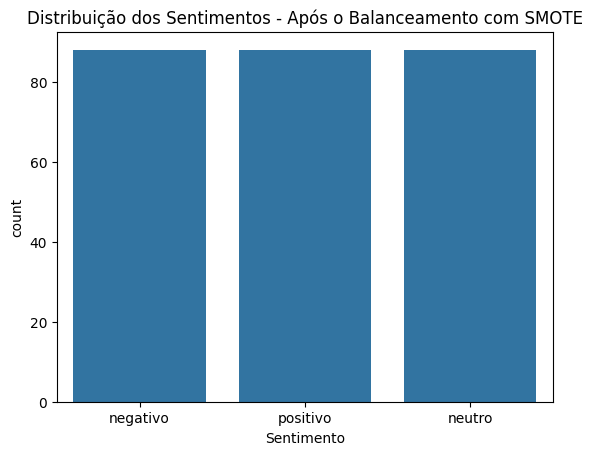

Quantidade de Sentimentos Positivos (após balanceamento): 88
Quantidade de Sentimentos Negativos (após balanceamento): 88
Quantidade de Sentimentos Neutros (após balanceamento): 88


In [42]:
# Sentimentos após o balanceamento
sentimento_counts_resampled = pd.Series(y_resampled).value_counts()

sns.countplot(x=y_resampled)
plt.title('Distribuição dos Sentimentos - Após o Balanceamento com SMOTE')
plt.xlabel('Sentimento')
plt.show()

print('Quantidade de Sentimentos Positivos (após balanceamento):', sentimento_counts_resampled.get('positivo', 0))
print('Quantidade de Sentimentos Negativos (após balanceamento):', sentimento_counts_resampled.get('negativo', 0))
print('Quantidade de Sentimentos Neutros (após balanceamento):', sentimento_counts_resampled.get('neutro', 0))

In [43]:
#traduzindo o tempo decorrido
import datetime
sec = end_time-start_time
print(str(datetime.timedelta(seconds = sec)))

0:00:00.008961


### Analisando os resultados do SVM


In [44]:
# f1_score, precision e acurácia 
print("F1_score:",metrics.f1_score(y_test, y_pred, average="weighted"))
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred, normalize=True))

F1_score: 0.5939112487100104
Precision: 0.625925925925926
Accuracy: 0.5833333333333334


## Desenvolvendo modelo de classificação usando extração de variáveis

In [45]:
# Preparação dos dados
X = df['content_Treated'].apply(lambda x: ' '.join(x)).values
y = df['sentimento'].values

# Dividir dados em treino e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Transformar rótulos de texto em valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  
y_test = label_encoder.transform(y_test)   

# Calcular pesos de classe
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')  # Move para GPU se disponível

# Tokenização com o tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [46]:
class GenshinDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        # Garantindo que os dados são retornados como tensores 2D
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = GenshinDataset(train_encodings, y_train)
val_dataset = GenshinDataset(val_encodings, y_test)

In [47]:
# Configurar o modelo
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Calcular a perda com class_weights
        loss = F.cross_entropy(logits, labels, weight=class_weights)
        
        return (loss, outputs) if return_outputs else loss

In [49]:
# Parâmetros de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [50]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [51]:
# Treinar o modelo
trainer.train()

  4%|▎         | 10/270 [00:03<01:24,  3.09it/s]

{'loss': 1.2345, 'grad_norm': 9.7675199508667, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.56}


  7%|▋         | 20/270 [00:06<01:15,  3.30it/s]

{'loss': 1.1584, 'grad_norm': 10.029195785522461, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.11}


 11%|█         | 30/270 [00:09<01:15,  3.19it/s]

{'loss': 1.0588, 'grad_norm': 6.577760696411133, 'learning_rate': 3e-06, 'epoch': 1.67}


 15%|█▍        | 40/270 [00:12<01:10,  3.27it/s]

{'loss': 1.0098, 'grad_norm': 6.360846996307373, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.22}


 19%|█▊        | 50/270 [00:15<01:09,  3.15it/s]

{'loss': 0.9227, 'grad_norm': 3.6737959384918213, 'learning_rate': 5e-06, 'epoch': 2.78}


 22%|██▏       | 60/270 [00:18<01:09,  3.02it/s]

{'loss': 0.9205, 'grad_norm': 8.221525192260742, 'learning_rate': 6e-06, 'epoch': 3.33}


 26%|██▌       | 70/270 [00:21<00:56,  3.51it/s]

{'loss': 0.9017, 'grad_norm': 7.111280918121338, 'learning_rate': 7.000000000000001e-06, 'epoch': 3.89}


 30%|██▉       | 80/270 [00:24<00:53,  3.56it/s]

{'loss': 0.7925, 'grad_norm': 5.337774276733398, 'learning_rate': 8.000000000000001e-06, 'epoch': 4.44}


 33%|███▎      | 90/270 [00:27<00:45,  3.99it/s]

{'loss': 0.9886, 'grad_norm': 10.234284400939941, 'learning_rate': 9e-06, 'epoch': 5.0}


 37%|███▋      | 100/270 [00:30<00:47,  3.56it/s]

{'loss': 0.7464, 'grad_norm': 4.048616409301758, 'learning_rate': 1e-05, 'epoch': 5.56}


 41%|████      | 110/270 [00:32<00:43,  3.67it/s]

{'loss': 0.9658, 'grad_norm': 7.154993534088135, 'learning_rate': 1.1000000000000001e-05, 'epoch': 6.11}


 44%|████▍     | 120/270 [00:35<00:41,  3.59it/s]

{'loss': 0.8594, 'grad_norm': 3.417813301086426, 'learning_rate': 1.2e-05, 'epoch': 6.67}


 48%|████▊     | 130/270 [00:38<00:37,  3.71it/s]

{'loss': 0.8401, 'grad_norm': 4.626450061798096, 'learning_rate': 1.3000000000000001e-05, 'epoch': 7.22}


 52%|█████▏    | 140/270 [00:41<00:35,  3.63it/s]

{'loss': 0.7031, 'grad_norm': 7.082793712615967, 'learning_rate': 1.4000000000000001e-05, 'epoch': 7.78}


 56%|█████▌    | 150/270 [00:44<00:35,  3.38it/s]

{'loss': 0.6726, 'grad_norm': 9.34635066986084, 'learning_rate': 1.5e-05, 'epoch': 8.33}


 59%|█████▉    | 160/270 [00:47<00:34,  3.17it/s]

{'loss': 0.6953, 'grad_norm': 13.158835411071777, 'learning_rate': 1.6000000000000003e-05, 'epoch': 8.89}


 63%|██████▎   | 170/270 [00:49<00:29,  3.44it/s]

{'loss': 0.6031, 'grad_norm': 15.950002670288086, 'learning_rate': 1.7000000000000003e-05, 'epoch': 9.44}


 67%|██████▋   | 180/270 [00:52<00:23,  3.82it/s]

{'loss': 0.5802, 'grad_norm': 6.768305778503418, 'learning_rate': 1.8e-05, 'epoch': 10.0}


 70%|███████   | 190/270 [00:55<00:22,  3.57it/s]

{'loss': 0.4706, 'grad_norm': 17.892087936401367, 'learning_rate': 1.9e-05, 'epoch': 10.56}


 74%|███████▍  | 200/270 [00:58<00:18,  3.80it/s]

{'loss': 0.6106, 'grad_norm': 5.357973575592041, 'learning_rate': 2e-05, 'epoch': 11.11}


 78%|███████▊  | 210/270 [01:01<00:16,  3.56it/s]

{'loss': 0.524, 'grad_norm': 23.371450424194336, 'learning_rate': 2.1e-05, 'epoch': 11.67}


 81%|████████▏ | 220/270 [01:03<00:14,  3.57it/s]

{'loss': 0.4241, 'grad_norm': 5.1861042976379395, 'learning_rate': 2.2000000000000003e-05, 'epoch': 12.22}


 85%|████████▌ | 230/270 [01:06<00:11,  3.54it/s]

{'loss': 0.301, 'grad_norm': 6.042303562164307, 'learning_rate': 2.3000000000000003e-05, 'epoch': 12.78}


 89%|████████▉ | 240/270 [01:09<00:08,  3.70it/s]

{'loss': 0.2487, 'grad_norm': 3.5600805282592773, 'learning_rate': 2.4e-05, 'epoch': 13.33}


 93%|█████████▎| 250/270 [01:12<00:05,  3.65it/s]

{'loss': 0.3025, 'grad_norm': 3.6564130783081055, 'learning_rate': 2.5e-05, 'epoch': 13.89}


 96%|█████████▋| 260/270 [01:14<00:02,  3.49it/s]

{'loss': 0.2815, 'grad_norm': 21.065168380737305, 'learning_rate': 2.6000000000000002e-05, 'epoch': 14.44}


100%|██████████| 270/270 [01:17<00:00,  3.97it/s]

{'loss': 0.266, 'grad_norm': 3.3721601963043213, 'learning_rate': 2.7000000000000002e-05, 'epoch': 15.0}


100%|██████████| 270/270 [01:27<00:00,  3.08it/s]

{'train_runtime': 87.7739, 'train_samples_per_second': 23.925, 'train_steps_per_second': 3.076, 'train_loss': 0.7067518260743882, 'epoch': 15.0}


TrainOutput(global_step=270, training_loss=0.7067518260743882, metrics={'train_runtime': 87.7739, 'train_samples_per_second': 23.925, 'train_steps_per_second': 3.076, 'total_flos': 138134544307200.0, 'train_loss': 0.7067518260743882, 'epoch': 15.0})

In [52]:
# Obtendo as previsões
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Convertendo os valores numéricos de volta para os rótulos originais
y_pred = label_encoder.inverse_transform(preds)

100%|██████████| 8/8 [00:00<00:00, 13.79it/s]


In [53]:
# Convertendo o valor numérico para categorias
y_test_val = label_encoder.inverse_transform(y_test)       

# f1_score, precision e acurácia Do Fine-Tuning com BERT
print("F1_score BERT:",metrics.f1_score(y_test_val, y_pred, average="weighted"))
print("Precision BERT:",metrics.precision_score(y_test_val, y_pred, average="weighted"))
print("Accuracy BERT:",metrics.accuracy_score(y_test_val, y_pred))

F1_score BERT: 0.5452783192549274
Precision BERT: 0.5619476268412439
Accuracy BERT: 0.5833333333333334


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
